In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# Visualizing a Coffee Shop in Vinnytsia, Ukraine: Patterns by Sales Volume, Hour of the Day, and Seasons

Author: **Caio Maxximus**

<div style="display: flex; gap: 10px;"> 
    <a href="https://github.com/CaioMaxximus" target="_blank"><img src="https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white" target="_blank"></a>  
    <a href="https://www.linkedin.com/in/caiomaxximus/" target="_blank"><img src="https://img.shields.io/badge/-LinkedIn-%230077B5?style=for-the-badge&logo=linkedin&logoColor=white" target="_blank"></a>
  <a href="https://www.hackerrank.com/profile/puntmaxximus" target="_blank"><img src="https://img.shields.io/badge/HackerRank-%F0%9F%9F%A9-black?style=for-the-badge&labelColor=black" target="_blank"></a>

</div>

In [2]:
# BUILDING SOME UTILITY FUNCTIONS TO CREATE ATRIBUTES FOR PERIOD AND SEASON

def period_maker(val):
    if val <= 12:
        return 0
    elif val <= 17:
        return 1
    else:
        return 2
def season_maker(val):
    if val <= 2 or val >=12:
        return 0
    elif val <= 6:
        return 1
    elif val <= 9:
        return 2
    else:
        return 3

seasons_map = {
    0 : 'Winter',
    1 :'Spring',
    2 :'Summer',
    3 :'Autumn'
}

# This dictionary defines the seasons in the Northern Hemisphere based on:  
# solstices (marking winter and summer) and equinoxes (marking spring and autumn).  
# The dates are derived from the official astronomical calendar for 2024.  
seasons = {
    'Winter': ['2023-12-21', '2024-03-19'],  # December Solstice to March Equinox
    'Spring': ['2024-03-20', '2024-06-20'],  # March Equinox to June Solstice
    'Summer': ['2024-06-20', '2024-09-22'],  # June Solstice to September Equinox
    'Autumn': ['2024-09-22', '2024-12-21']   # September Equinox to December Solstice
}


## **Data Overview**

In [3]:
data = pd.read_csv("/kaggle/input/coffee-sales/index.csv")
(data.dtypes)

date            object
datetime        object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object

In [4]:
data.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [5]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

missing_dates = all_dates.difference(data.index)

if len(missing_dates) > 0:
    print(f"Number of missing days: {len(missing_dates)}")
    print(missing_dates)
else:
    print("Any day missing")

Number of missing days: 6
DatetimeIndex(['2024-05-01', '2024-05-04', '2024-05-05', '2024-11-27',
               '2025-01-01', '2025-01-19'],
              dtype='datetime64[ns]', freq=None)


## **Vizualizing Sales behaviour**

In [6]:
data = data.reset_index()
data["datetime"] = pd.to_datetime(data["datetime"])
data["date"] = pd.to_datetime(data["date"])
data["hour"] = data["datetime"].dt.hour
data["month"] = data["date"].dt.month
data["weekday"] = data["date"].dt.weekday
data["week_of_year"] = data["datetime"].dt.isocalendar().week
# data["start_week_of_month"] = data["datetime"].dt.to_period("M").apply(lambda x: x.start_time).dt.isocalendar().week
# data["week_of_month"] = list(map(int , (data["week_of_year"] - data["start_week_of_month"] + 1)))
data.drop(["datetime" , "cash_type" , "card","money"] ,axis = 1 ,inplace = True)
data

,date,coffee_name,hour,month,weekday,week_of_year
0,2024-03-01,Latte,10,3,4,9
1,2024-03-01,Hot Chocolate,12,3,4,9
2,2024-03-01,Hot Chocolate,12,3,4,9
3,2024-03-01,Americano,13,3,4,9
4,2024-03-01,Latte,13,3,4,9
...,...,...,...,...,...,...
2833,2025-01-22,Cocoa,18,1,2,4
2834,2025-01-22,Americano with Milk,19,1,2,4
2835,2025-01-22,Cappuccino,19,1,2,4
2836,2025-01-22,Latte,19,1,2,4


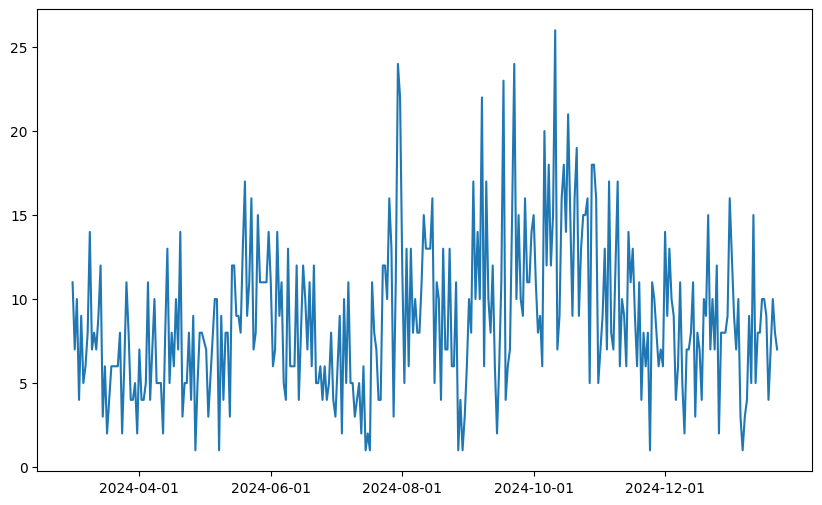

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data.groupby(["date"]).size())
plt.xticks(["2024-04-01","2024-06-01","2024-08-01","2024-10-01","2024-12-01"])
plt.show()

## Verifying seasonality hipothetisys

In [8]:
s_test = data.groupby(["date"]).size()
kpss_result = kpss(s_test, regression="c")
print("KPSS TEST")
print("p-value:", kpss_result[1])
if kpss_result[1] < 0.05:
    print("Series are not stationary")
else:
    print("Series are stationary")

adf_result = adfuller(s_test)
print("\nADFULLER TEST")
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("Series are stationary")
else:
    print("Series are not stationary")

KPSS TEST
p-value: 0.015990680170438386
Series are not stationary

ADFULLER TEST
p-value: 0.00286978998702991
Series are stationary


#### 📌*The test results shows that the series is stationary with a trend*

## *Daily data*

#### 📌*Using the last valid value to fill the empty dates*

<ipython-input-9-52ba54b3a84f>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data[0] = daily_data[0].fillna(method='ffill')


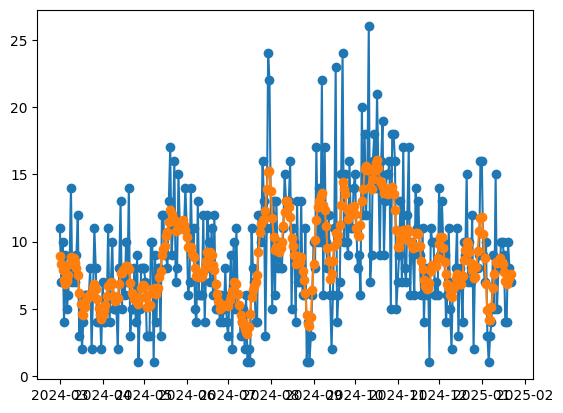

<Figure size 1000x600 with 0 Axes>

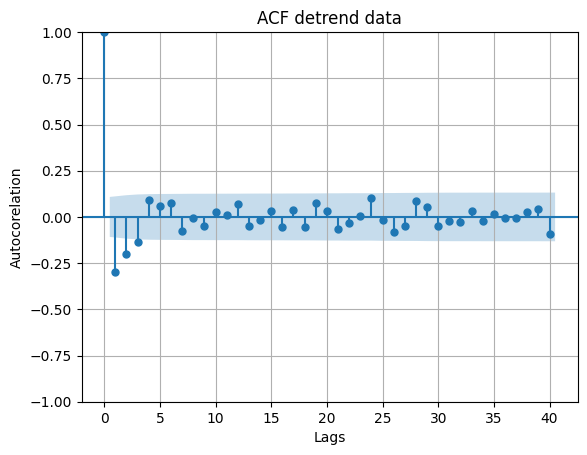

In [9]:

daily_data = data.groupby(["date"]).size().to_frame().reindex(all_dates)
## Filling the missing days
daily_data[0] = daily_data[0].fillna(method='ffill')
trend = daily_data[0].rolling(window=7, win_type='triang',center=True ,min_periods = 1).mean()
plt.plot(daily_data[0] ,'-o' )
plt.plot(trend ,'-o')
plt.show()
detrended_daily =daily_data[0] - trend
plt.figure(figsize=(10, 6))
plot_acf(detrended_daily, lags=40)
plt.title("ACF detrend data")
plt.xlabel("Lags")
plt.ylabel("Autocorelation")
plt.grid()
plt.show()

### *Testing the stationarity in the residuals*

In [10]:
kpss_result = kpss(detrended_daily.values, regression="c")
print("KPSS TEST")
print("p-value:", kpss_result[1])
if kpss_result[1] < 0.05:
    print("Residuals are not stationary")
else:
    print("Residuals are stationary")

adf_result = adfuller(detrended_daily.values)
print("\nADFULLER TEST")
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("Residuals are stationary")
else:
    print("Residuals are not stationary")

KPSS TEST
p-value: 0.1
Residuals are stationary

ADFULLER TEST
p-value: 6.638803710533816e-14
Residuals are stationary


<ipython-input-10-9b024f3b7702>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(detrended_daily.values, regression="c")


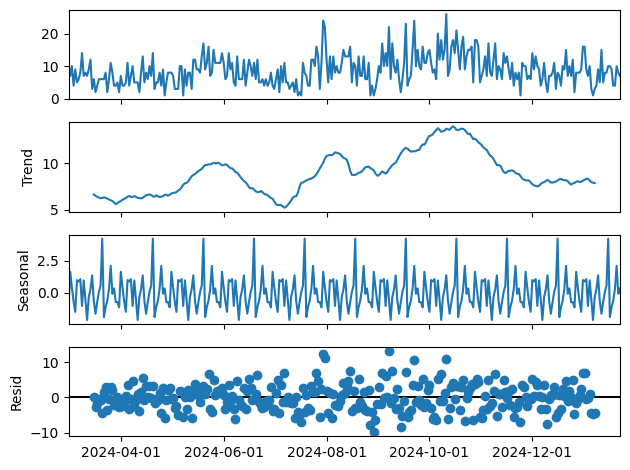

In [11]:
result = seasonal_decompose(daily_data, model='additive',period = 30)
result.plot()
plt.xticks(["2024-04-01","2024-06-01","2024-08-01","2024-10-01","2024-12-01"])
plt.show()

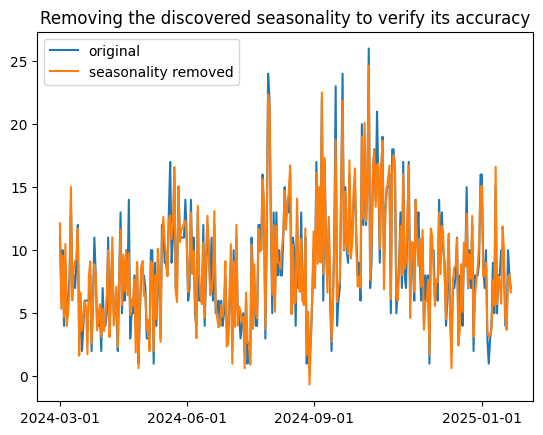

In [12]:
plt.plot(daily_data.dropna(),label = "original")
plt.plot(daily_data[0] - result.seasonal , label ="seasonality removed")
plt.legend()
plt.title("Removing the discovered seasonality to verify its accuracy")
plt.xticks(["2024-03-01","2024-06-01","2024-09-01","2025-01-01"])
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.show()

### 📌*The series with the removed seasonality is too close to the original data, indicating that the identified seasonality does not have significant meaning to explain the series behavior. Additionally, in the previous plot, the ACF of the detrended series did not show any relevant pattern. The stationarity tests applied to the residuals also confirm that they do not contain any meaningful patterns.*

## *Weekly data*

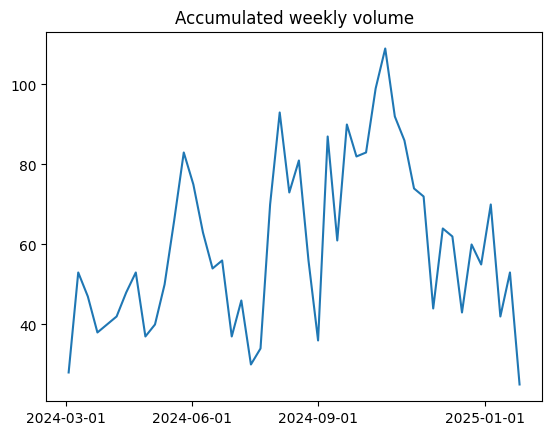

In [13]:
weekly_data = daily_data.resample('W').sum()
# plt.plot(data.groupby(["date"]).size().resample('W').sum().to_frame())
plt.plot(weekly_data)
# plt.plot(np.log(data.groupby(["date"]).size().resample('W').sum().to_frame()))
plt.xticks(["2024-03-01","2024-06-01","2024-09-01","2025-01-01"])
plt.title("Accumulated weekly volume")
plt.show()

<Figure size 1000x600 with 0 Axes>

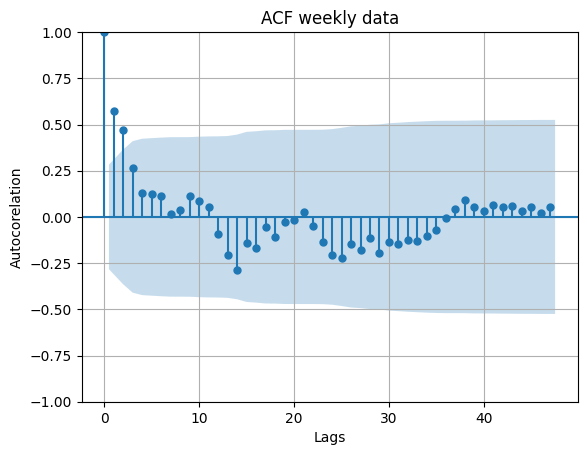

In [14]:
# re =data.groupby(["date"]).size().resample('W').sum().to_frame()
re = weekly_data
plt.figure(figsize=(10, 6))
plot_acf(re, lags=re.size - 1)
plt.title("ACF weekly data")
plt.xlabel("Lags")
plt.ylabel("Autocorelation")
plt.grid()
plt.show()

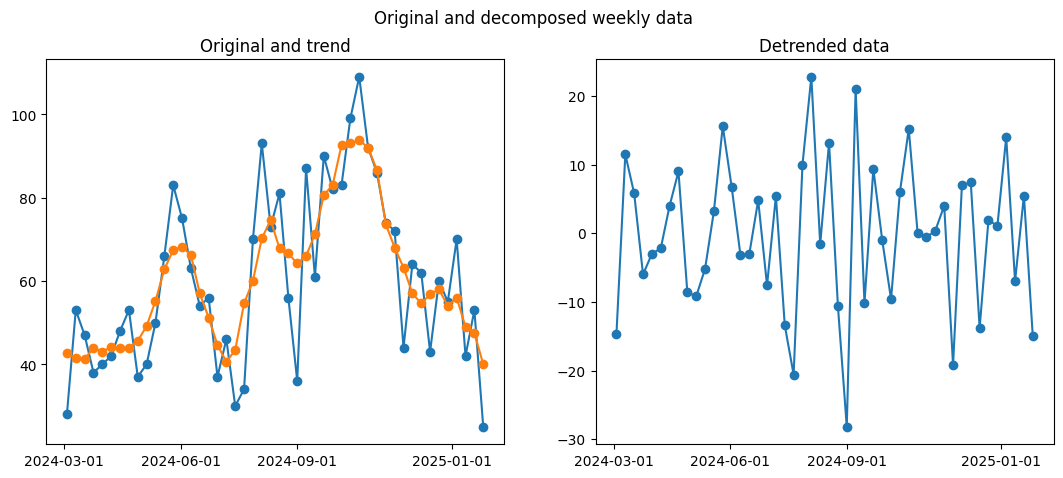

In [15]:
## Using decomposition to search for patterns in the data
time_series = weekly_data.sort_index()
period = 5
trend = weekly_data.rolling(window=period,min_periods = 1 ,center=True).mean()
detrend_data = time_series - trend

fig, axes = plt.subplots(1, 2, figsize=(13, 5)) 

fig.suptitle("Original and decomposed weekly data")
axes[0].plot(time_series,'-o')
axes[0].plot(trend , '-o')
axes[0].set_xticks(["2024-03-01","2024-06-01","2024-09-01","2025-01-01"])
axes[0].set_title("Original and trend")

axes[1].plot(detrend_data , '-o')
axes[1].set_xticks(["2024-03-01","2024-06-01","2024-09-01","2025-01-01"])
axes[1].set_title("Detrended data")
plt.show()

<Figure size 1000x600 with 0 Axes>

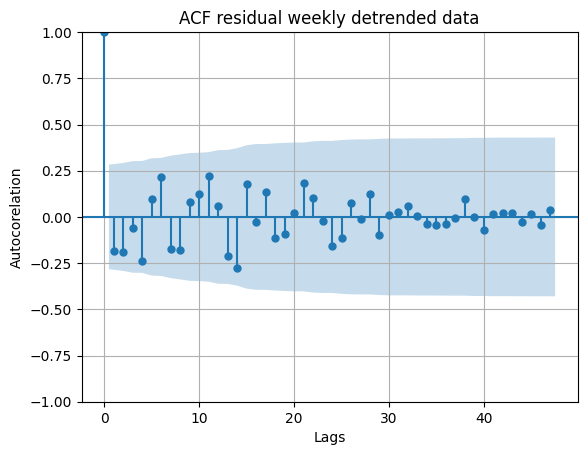

In [16]:
re = detrend_data
plt.figure(figsize=(10, 6))
plot_acf(re, lags=re.size - 1)
plt.title("ACF residual weekly detrended data")
plt.xlabel("Lags")
plt.ylabel("Autocorelation")
plt.grid()
plt.show()

### 📌*There is no strong pattern in the data showing seasonality, nor weekly nor monthly. With less than one year of data available, the visualization is limited.*

## **Building a forecast**

### ***Arima model***

0    4.569899
dtype: float64


<Figure size 1000x600 with 0 Axes>

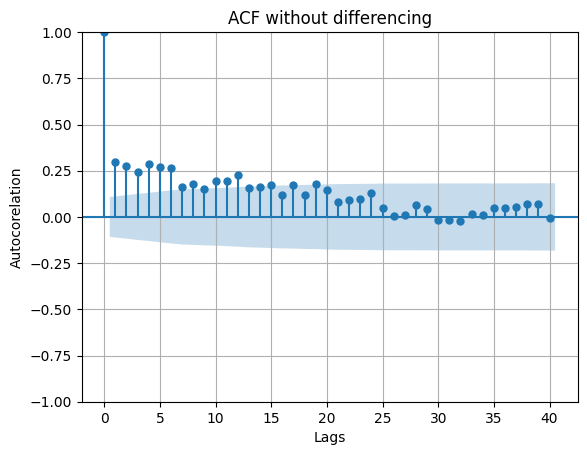

In [17]:
re = daily_data
print(re.std())
plt.figure(figsize=(10, 6))
plot_acf(re, lags=40)
plt.title("ACF without differencing")
plt.xlabel("Lags")
plt.ylabel("Autocorelation")
plt.grid()
plt.show()

0    5.421484
dtype: float64


<Figure size 1000x600 with 0 Axes>

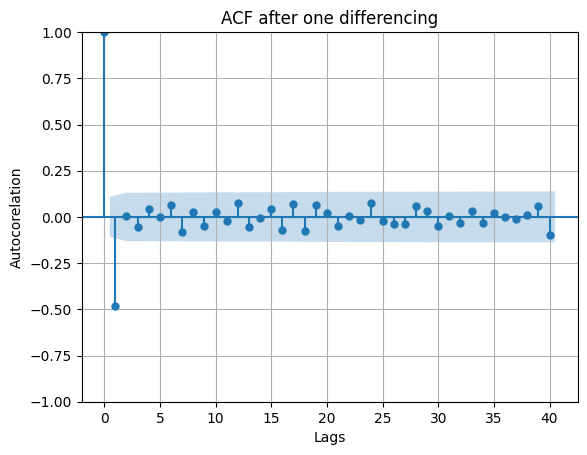

In [18]:
re = daily_data.diff().dropna()
print(re.std())
plt.figure(figsize=(10, 6))
plot_acf(re, lags=40)
plt.title("ACF after one differencing")
plt.xlabel("Lags")
plt.ylabel("Autocorelation")
plt.grid()
plt.show()

### 📌*The non-differentiated data shows a lower standard deviation, while the differentiated data exhibits a strong negative relationship in the first lag. Therefore, the non-differentiated data will be used in the ARIMA model.*

<Figure size 1000x600 with 0 Axes>

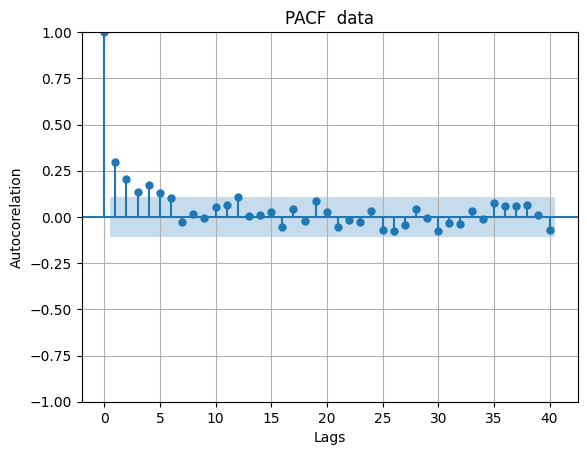

In [19]:
re = daily_data
# print(re.std())
plt.figure(figsize=(10, 6))
plot_pacf(re, lags=40)
plt.title("PACF  data")
plt.xlabel("Lags")
plt.ylabel("Autocorelation")
plt.grid()
plt.show()

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# diff_data = daily_data.diff().dropna()
diff_data =  daily_data
train_size = int(len(diff_data) * 0.75)
train, test = diff_data[:train_size], daily_data[train_size:] 

# Ajustando o modelo ARIMA
model = ARIMA(train, order=(6,0, 2))  # Ajuste os valores de p, d, q conforme necessário
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      0   No. Observations:                  246
Model:                 ARIMA(6, 0, 2)   Log Likelihood                -702.806
Date:                Fri, 31 Jan 2025   AIC                           1425.612
Time:                        12:42:01   BIC                           1460.665
Sample:                    03-01-2024   HQIC                          1439.726
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9821      1.106      8.118      0.000       6.814      11.151
ar.L1         -0.1508      0.643     -0.234      0.815      -1.412       1.110
ar.L2          0.0631      0.421      0.150      0.881      -0.761       0.887
ar.L3          0.1286      0.095      1.359      0.174      -0.057       0.314
ar.L4          0.1818      0.083      2.188      0.029       0.019       0.345
ar.L5          0.2345      0.098      2.391      0.017       0.042       0.427
ar.L6          0.1686      0.114      1.483      0.138      -0.054       0.391
ma.L1          0.2976      0.640      0.465      0.642      -0.958       1.553
ma.L2          0.0731      0.377      0.194      0.846      -0.667       0.813
sigma2        17.6937      1.555     11.378      0.000      14.646      20.742
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                18.84
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

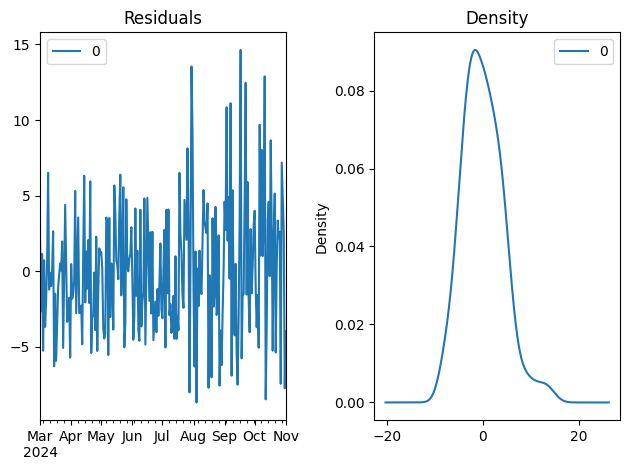

In [21]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()


RMSE: 3.62850443753042


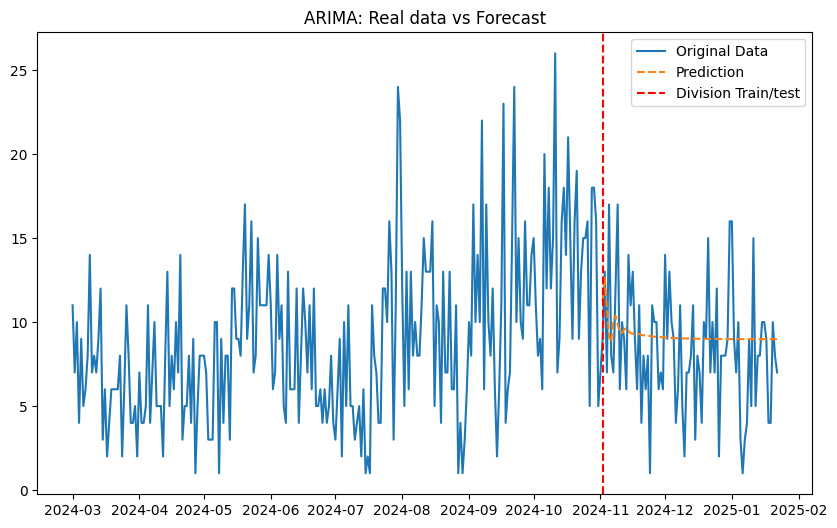

In [22]:
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)


rmse = np.sqrt(mean_squared_error(daily_data.iloc[train_size :], forecast))
print(f"\nRMSE: {rmse}")

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(daily_data, label="Original Data")
plt.plot(forecast, label="Prediction", linestyle="--")
plt.axvline(x=daily_data.index[train_size], color="red", linestyle="--", label="Division Train/test")
plt.legend()
plt.title("ARIMA: Real data vs Forecast")
plt.show()

### 📌*The model predicts movement based on the average trend of the series due to its noisy behavior.*

## **Visulazing season partners**

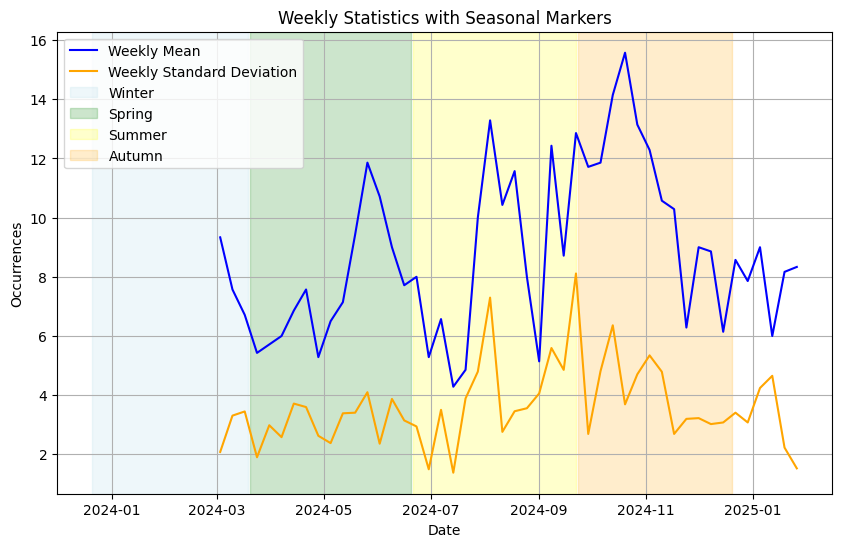

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(data.groupby(["date"]).size().resample('W').mean().to_frame().sort_index(), label='Weekly Mean', color='blue')
plt.plot(data.groupby(["date"]).size().resample('W').std().to_frame(), label='Weekly Standard Deviation' , color='orange')
data["season"] =  data["month"].apply(season_maker)

seasons = {
    'Winter': ['2023-12-21', '2024-03-19'],  
    'Spring': ['2024-03-20', '2024-06-20'],  
    'Summer': ['2024-06-21', '2024-09-22'],  
    'Autumn': ['2024-09-23', '2024-12-20']  
}

season_colors = {
    'Winter': 'lightblue',
    'Spring': 'green',
    'Summer': 'yellow',
    'Autumn': 'orange'
}

for season, dates in seasons.items():
    start, end = pd.to_datetime(dates)
    plt.axvspan(start, end, alpha=0.2, color=season_colors[season], label=season)

plt.title('Weekly Statistics with Seasonal Markers')
plt.xlabel('Date')
plt.ylabel('Occurrences')
plt.legend()
plt.grid(True)
plt.show()

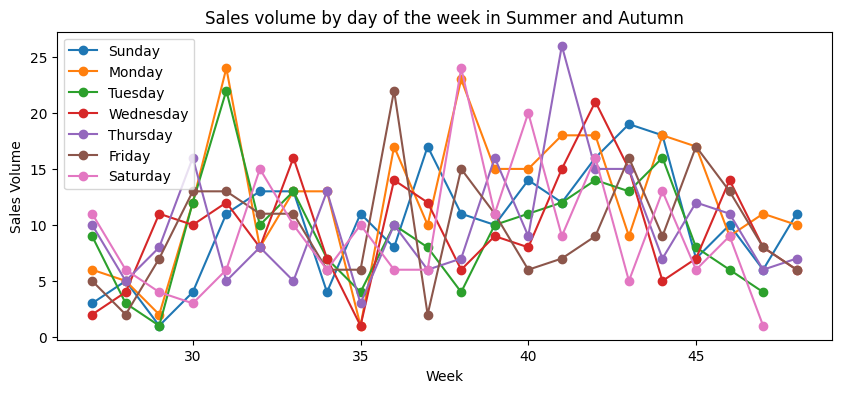

In [24]:
plt.figure(figsize=(10, 4))
dic_week_days = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

data["season"] =  data["month"].apply(season_maker)
selected = data.loc[data["season"].isin([2,3])].groupby(["weekday", "date","week_of_year"]).size().reset_index(name = "sales")
for day in range(0,7):
    d_plot = selected.loc[selected["weekday"] == day]
    plt.plot( d_plot["week_of_year"],d_plot["sales"], '-o',label = dic_week_days[day])
plt.title("Sales volume by day of the week in Summer and Autumn")
plt.xlabel('Week')
plt.ylabel('Sales Volume')
plt.legend()
plt.show()

### 📌*The standard deviation increases during Summer and Autumn. Below is a plot with additional data for these two seasons*

## *Vizualizing occurence of outliers during the summer and autumn season in the detrend data*

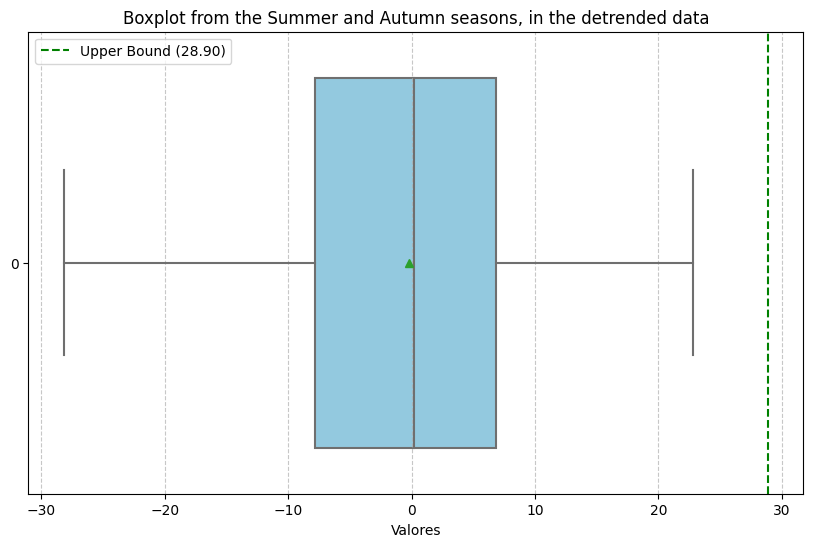

In [25]:

Q1 = np.percentile(detrend_data, 25)
Q3 = np.percentile(detrend_data, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = detrend_data[(detrend_data < lower_bound) | (detrend_data > upper_bound)].dropna()

plt.figure(figsize=(10, 6))
sns.boxplot(detrend_data, orient='h', color='skyblue', showmeans=True)

plt.axvline(upper_bound, color='green', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')

plt.title("Boxplot from the Summer and Autumn seasons, in the detrended data")
plt.xlabel('Valores')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [26]:
outliers

,0


### 📌*Any outliers were detected in the detrended data*

## ✨ **City Events on Sales Trends** ✨
#### *Looking some events that happened in the city during the year*

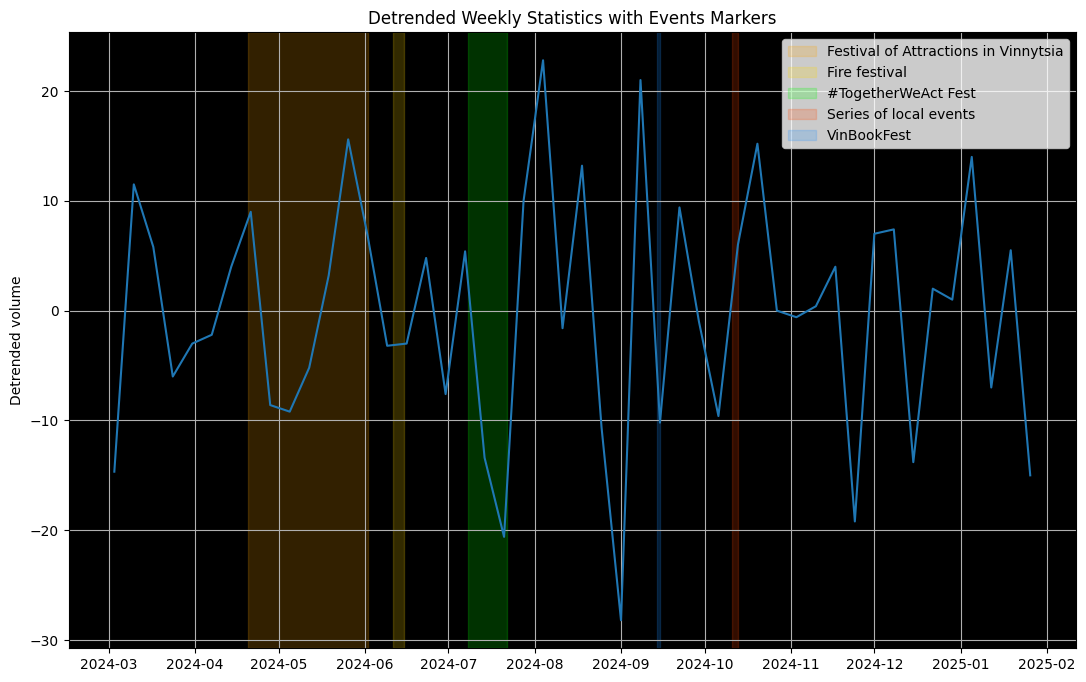

In [27]:
plt.figure(figsize=(13, 8))
plt.plot(detrend_data)

events = {
    "Festival of Attractions in Vinnytsia" : ["2024-04-20" , "2024-06-02"],
    "Fire festival" : ["2024-06-11" , "2024-06-15"],
    "#TogetherWeAct Fest": ['2024-07-08', '2024-07-22'],
    "Series of local events": ['2024-10-11', '2024-10-13'],
    "VinBookFest": ['2024-09-14', '2024-09-15'],
}

    # 'Winter': ['2023-12-21', '2024-03-19'],  

event_colors = {
    "January events": "fuchsia",
    "Festival of Attractions in Vinnytsia": "orange",
    "Fire festival": "gold",
    "#TogetherWeAct Fest": "lime",
    "Series of local events" : "orangered",
    "VinBookFest": "dodgerblue",
}

for event, dates in events.items():
    start, end = pd.to_datetime(dates)
    plt.axvspan(start, end, alpha=0.2, color=event_colors[event], label=event)

plt.title('Detrended Weekly Statistics with Events Markers')
plt.ylabel('Detrended volume')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor("black")

plt.show()

* **[Festival of Attractions in Vinnytsia](https://moemisto.ua/vn/festival-atraktsioniv-u-vinnitsi-270003.html):** A daily festival featuring various attractions, open from 12:00 PM to 10:00 PM. 

* **[VinBookFest](https://misto.vn.ua/culture/u-vinnici-vidbudetsya-odinadcyatij-festival-vinbookfest/):** Scheduled for September 14–15, this festival celebrates books and literature with engaging activities and exhibitions. 

* **[#TogetherWeAct Fest](https://eu4ukraine.eu/en/whats-happening-en/news-en/vinnytsia-will-host-togetherweact-fest.html):** This community-focused event runs from July 8 to July 22, promoting unity through cultural and social initiatives.

* **[Local Weekend Events](https://presspoint.in.ua/2024/10/10/dobirka-dozvillia-dlia-vinnychan-na-vikend-11-13-zhovtnia/):** A series of leisure activities and events taking place from October 11 to October 13, designed for residents and visitors alike.

* **[Living Fire Festival](https://vn.20minut.ua/Podii/u-vinnitsi-vidbudetsya-mizhnarodniy-festival-zhiviy-vogon-scho-chekae--11931312.html):** An international fire arts festival on June 22, 2024.

### 📌*Events and sales volume seem to exhibit a negative relationship, but without the store location or the number of people attending for each event, this assertion is stronger than what the data supports.*

## **Sales hours trends**
##  *Sales behaviour in differents hours, periods and seasons*

In [28]:
periods_name = {
    0 : "Morning",
    1 : "Afternoon",
    2 : "Night"}

data["period"] = data["hour"].apply(period_maker)
data["period_label"] = data["period"].map(periods_name)

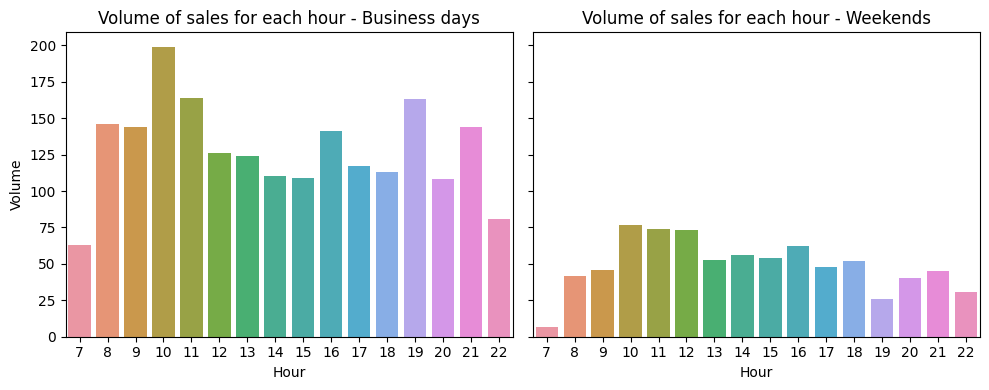

In [29]:
weekdays = data[data["weekday"].isin(range(0, 5))]
weekends = data[data["weekday"].isin(range(5, 7))]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.countplot(ax=axes[0], x=weekdays["hour"])
axes[0].set_title("Volume of sales for each hour - Business days")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Volume")

sns.countplot(ax=axes[1], x=weekends["hour"])
axes[1].set_title("Volume of sales for each hour - Weekends")
axes[1].set_xlabel("Hour")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

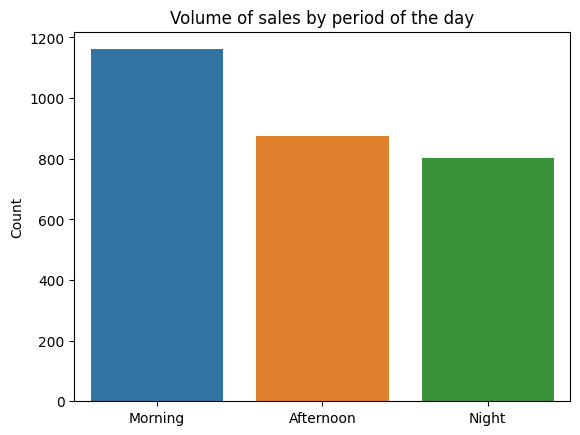

In [30]:
sns.countplot(x=data["period_label"])
plt.xlabel("")  
plt.ylabel("Count")   
plt.title("Volume of sales by period of the day")
plt.show()

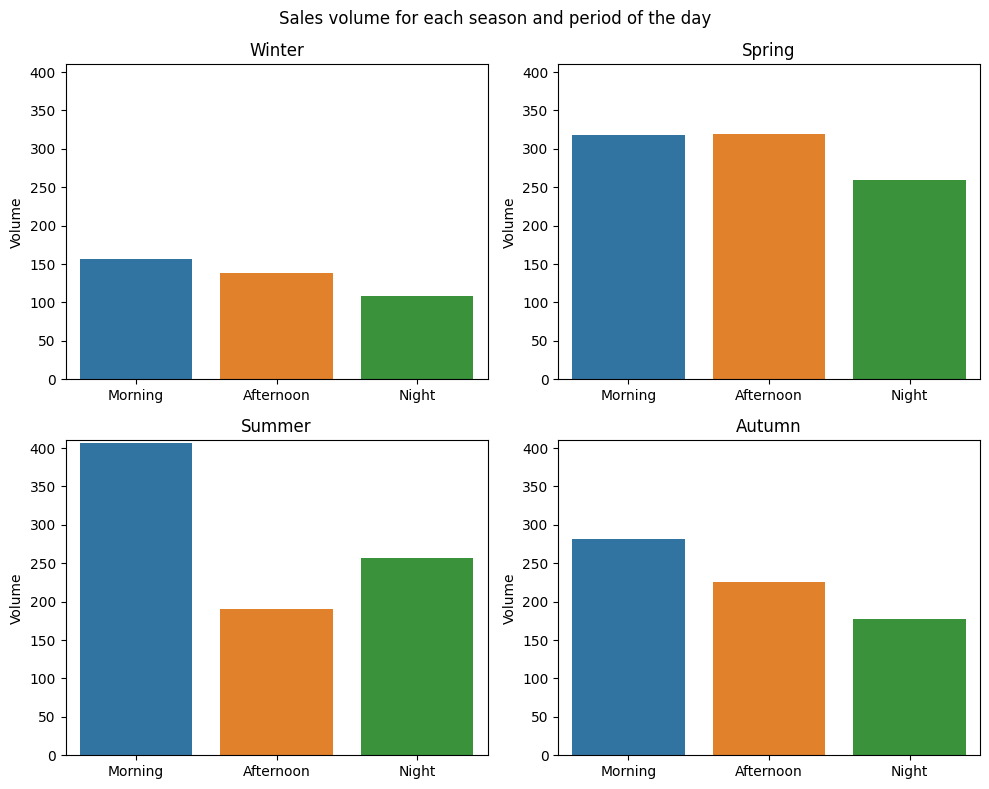

In [31]:

fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 
axes = axes.flatten()  
fig.suptitle("Sales volume for each season and period of the day")
for season in range(0, 4):
    ax = axes[season]
    sns.countplot(
        x=data.loc[data["season"] == season, "period_label"], 
        ax=ax,order = ["Morning" , "Afternoon","Night"]
    )
    ax.set_ylabel('Volume')  
    ax.set_xlabel('')  
    ax.set_title(f"{ seasons_map[season]}")
    ax.set_ylim((0,410))  


plt.tight_layout()
plt.show()

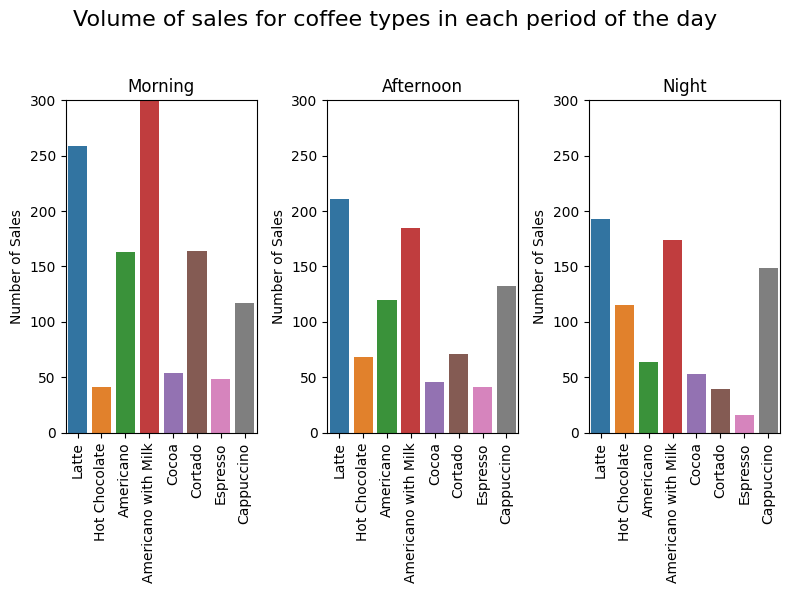

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(8, 6)) 
axes = axes.flatten()
fig.suptitle("Volume of sales for coffee types in each period of the day", fontsize=16)

unique_coffee_names = data["coffee_name"].unique()
y_range = (0, 300)  
y_label = "Number of Sales"

for p in [0, 1, 2]:
    ax = axes[p]
    sns.countplot(
        x=data.loc[data["period"] == p, "coffee_name"],
        order=unique_coffee_names,
        ax=ax,
        orient='vertical'
    )
    ax.set_title(f"{periods_name[p]}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylim(y_range)  
    ax.set_ylabel(y_label)  
    ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

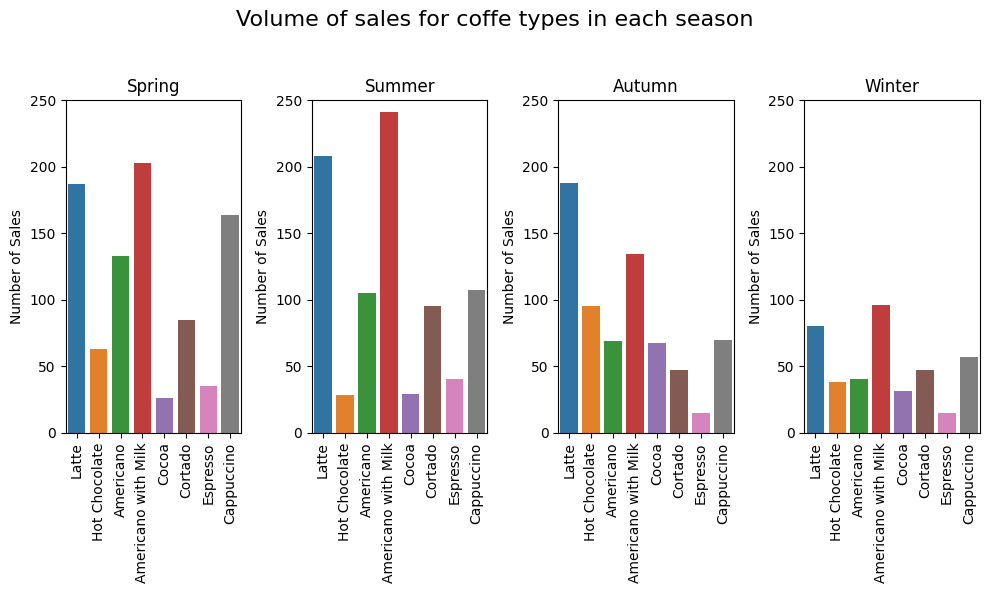

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(10, 6)) 
axes = axes.flatten()
data["season_name"] = data["season"].map(seasons_map)

fig.suptitle("Volume of sales for coffe types in each season", fontsize=16)
unique_coffee_names = data["coffee_name"].unique()
seasons = data["season_name"].unique()
y_range = (0, 250)  
y_label = "Number of Sales"

for i , s in enumerate(seasons):
    ax = axes[i]
    sns.countplot(x=data.loc[data["season_name"] == s, "coffee_name"],
                   order= unique_coffee_names,
                  ax=ax,orientation='vertical')
    ax.set_title(f"{s}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylim(y_range)  
    ax.set_ylabel(y_label)  
    ax.set_xlabel("")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### **Comment below if you any additional information or there is any errors in this notebook.Thanks!**